In [9]:
import cv2 as cv  # 导入opencv包
import numpy as np  # 导入numpy包，图像处理中的矩阵运算需要用到
import matplotlib.pyplot as plt


# 检测图像的SIFT关键特征点
def sift_keypoints_detect(image):
    # 处理图像一般很少用到彩色信息，通常直接将图像转换为灰度图
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # 获取图像特征sift-SIFT特征点,实例化对象sift
    # sift = cv.xfeatures2d.SIFT_create()
    sift = cv.SIFT_create()

    # keypoints:特征点向量,向量内的每一个元素是一个KeyPoint对象，包含了特征点的各种属性信息(角度、关键特征点坐标等)
    # features:表示输出的sift特征向量，通常是128维的
    keypoints, features = sift.detectAndCompute(image, None)

    # cv.drawKeyPoints():在图像的关键特征点部位绘制一个小圆圈
    # 如果传递标志flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,它将绘制一个大小为keypoint的圆圈并显示它的方向
    # 这种方法同时显示图像的坐标，大小和方向，是最能显示特征的一种绘制方式
    keypoints_image = cv.drawKeypoints(
        gray_image, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # 返回带关键特征点的图像、关键特征点和sift的特征向量
    return keypoints_image, keypoints, features


# 使用KNN检测来自左右图像的SIFT特征，随后进行匹配
def get_feature_point_ensemble(features_right, features_left):
    # 创建BFMatcher对象解决匹配
    bf = cv.BFMatcher()
    # knnMatch()函数：返回每个特征点的最佳匹配k个匹配点
    # features_right为模板图，features_left为匹配图
    matches = bf.knnMatch(features_right, features_left, k=2)
    # 利用sorted()函数对matches对象进行升序(默认)操作
    # x:x[]字母可以随意修改，排序方式按照中括号[]里面的维度进行排序，[0]按照第一维排序，[2]按照第三维排序
    matches = sorted(matches, key=lambda x: x[0].distance / x[1].distance)

    # 建立列表good用于存储匹配的点集
    good = []
    for m, n in matches:
        # ratio的值越大，匹配的线条越密集，但错误匹配点也会增多
        ratio = 0.6
        if m.distance < ratio * n.distance:
            good.append(m)

    # 返回匹配的关键特征点集
    return good


# 计算视角变换矩阵H，用H对右图进行变换并返回全景拼接图像
def panorama_stitching(image_right, image_left):
    _, keypoints_right, features_right = sift_keypoints_detect(image_right)
    _, keypoints_left, features_left = sift_keypoints_detect(image_left)
    goodMatch = get_feature_point_ensemble(features_right, features_left)

    # 当筛选项的匹配对大于4对(因为homography单应性矩阵的计算需要至少四个点)时,计算视角变换矩阵
    if len(goodMatch) > 4:
        # 获取匹配对的点坐标
        ptsR = np.float32(
            [keypoints_right[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ptsL = np.float32(
            [keypoints_left[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)

        # ransacReprojThreshold：将点对视为内点的最大允许重投影错误阈值(仅用于RANSAC和RHO方法时),若srcPoints和dstPoints是以像素为单位的，该参数通常设置在1到10的范围内
        ransacReprojThreshold = 4

        # cv.findHomography():计算多个二维点对之间的最优单映射变换矩阵 H(3行x3列),使用最小均方误差或者RANSAC方法
        # 函数作用:利用基于RANSAC的鲁棒算法选择最优的四组配对点，再计算转换矩阵H(3*3)并返回,以便于反向投影错误率达到最小
        homography, status = cv.findHomography(
            ptsR, ptsL, cv.RANSAC, ransacReprojThreshold)

        # cv.warpPerspective()：透视变换函数，用于解决cv2.warpAffine()不能处理视场和图像不平行的问题
        # 作用：就是对图像进行透视变换，可保持直线不变形，但是平行线可能不再平行
        panorama = cv.warpPerspective(
            image_right, homography, (image_right.shape[1] + image_left.shape[1], image_right.shape[0]))

        # cv.imshow("left side after transform", panorama)
        # plt.imshow(panorama)
        # plt.show()

        # 将左图加入(部分覆盖)到变换后的右图像的左端即获得最终图像
        panorama[0:image_left.shape[0], 0:image_left.shape[1]] = image_left
        # 通过仅允许左图的非0像素点覆盖右图来防止左图的右侧黑色缺口覆盖左图
        for w in range(image_left.shape[0]):
            for h in range(image_left.shape[1]):
                b = image_left[w][h][0]
                g = image_left[w][h][1]
                r = image_left[w][h][2]
                if b == 0 and g == 0 and r == 0:
                    continue
                panorama[w][h] = image_left[w][h]

        w_edge = panorama.shape[0]
        print("shape[0] = " + str(w_edge))
        # 去除拼接后图片右侧的黑色区域
        flag = False
        while w_edge >= 0:
            w_edge -= 1
            h_line = panorama[:, w_edge]
            for bgr in h_line:
                if bgr[0] != 0 or bgr[1] != 0 or bgr[2] != 0:
                    flag = True
                    print("w_edge = " + str(w_edge))
                    break
            if flag:
                panorama = panorama[:,:w_edge,:]
                break

        # 返回全景拼接的图像
        print(panorama.shape)
        return panorama

In [10]:
def stich(image_left, image_right):
    # 通过调用cv2.resize()使用插值的方式来改变图像的尺寸，保证左右两张图像大小一致
    # cv.resize()函数中的第二个形参dsize表示输出图像大小尺寸，当设置为0(None)时，则表示按fx与fy与原始图像大小相乘得到输出图像尺寸大小
    # image_right = cv.resize(image_right, None, fx=0.4, fy=0.24)
    image_right = cv.resize(image_right, None, fx=0.8, fy=0.9)
    image_left = cv.resize(image_left, (image_right.shape[1], image_right.shape[0]))

    # 获取检测到关键特征点后的图像的相关参数
    keypoints_image_right, keypoints_right, features_right = sift_keypoints_detect(image_right)
    keypoints_image_left, keypoints_left, features_left = sift_keypoints_detect(image_left)

    # 利用np.hstack()函数同时将原图和绘有关键特征点的图像沿着竖直方向(水平顺序)堆叠起来
    # cv.imshow("detected key points in left side", np.hstack((image_left, keypoints_image_left)))
    # plt.imshow(np.hstack((image_left, keypoints_image_left)))
    # plt.show()

    # cv.imshow("detected key points in right side", np.hstack((image_right, keypoints_image_right)))
    # plt.imshow(np.hstack((image_right, keypoints_image_right)))
    # plt.show()

    goodMatch = get_feature_point_ensemble(features_right, features_left)
    # goodMatch = get_feature_point_ensemble(features_left, features_right)

    # cv.drawMatches():在提取两幅图像特征之后，画出匹配点对连线
    # matchColor – 匹配的颜色（特征点和连线),若matchColor==Scalar::all(-1),颜色随机
    all_goodmatch_image = cv.drawMatches(
        image_right, keypoints_right, image_left, keypoints_left, goodMatch, None, None, None, None, flags=2)
    cv.imshow("connect all matched sift key points between left and right sides", all_goodmatch_image)
    plt.imshow(all_goodmatch_image)
    plt.show()

    # Stitch images into panoramas
    panorama = panorama_stitching(image_right, image_left)
    # plt.imshow(panorama)
    # plt.show()

    return panorama

# image_left = cv.imread("data/7.jpg")
# image_right = cv.imread("data/8.jpg")
# panorama1 = stich(image_left, image_right)
# plt.imshow(panorama1)
# plt.show()
# image_right = cv.imread("data/3.jpg")
# panorama1 = stich(panorama1, image_right)
# plt.imshow(panorama1)
# plt.show()
# image_left = cv.imread("data/2.jpg")
# image_right = cv.imread("data/3.jpg")
# panorama2 = stich(image_left, image_right)
# plt.imshow(panorama2)
# plt.show()
# panorama = stich(panorama1, panorama2)
# plt.imshow(panorama)
# plt.show()
# plt.imsave("panorama.jpg", panorama)

[1, 2, 3, 4, 5, 6, 7, 8]
1 + 2


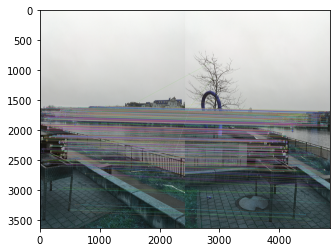

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
2 + 3


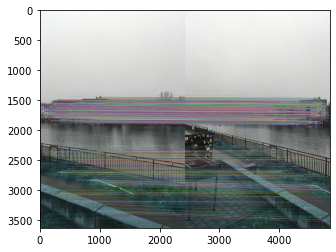

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
3 + 4


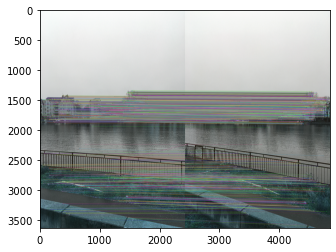

shape[0] = 3629
w_edge = 3174
(3629, 3174, 3)
4 + 5


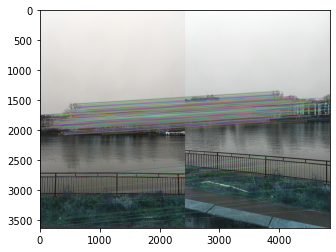

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
5 + 6


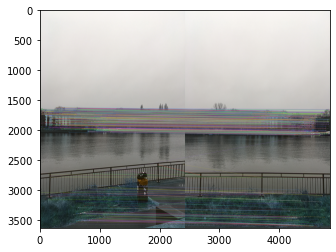

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
6 + 7


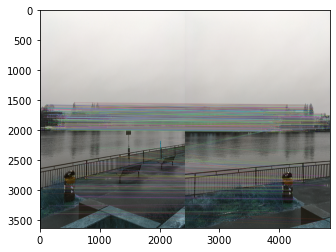

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
7 + 8


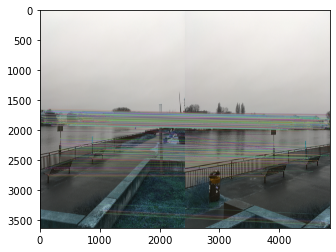

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
7
1 + 2


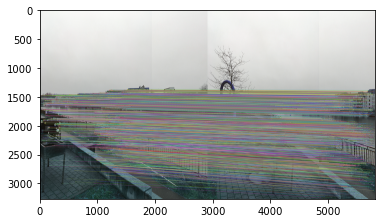

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
2 + 3


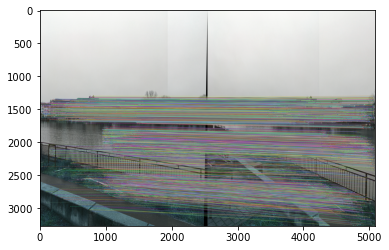

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
3 + 4


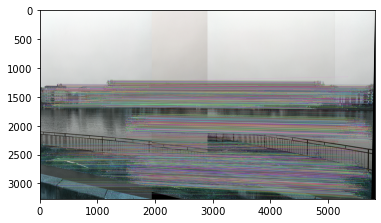

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
4 + 5


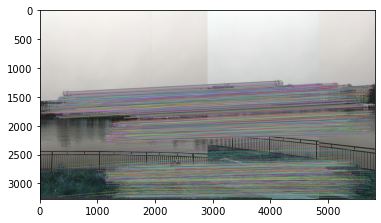

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
5 + 6


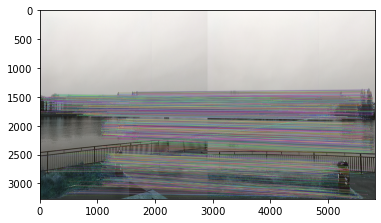

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
6 + 7


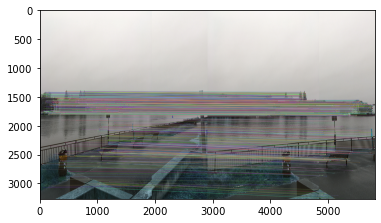

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
6
1 + 2


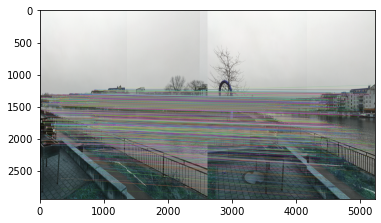

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
2 + 3


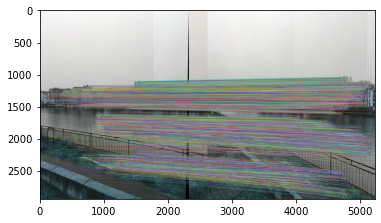

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
3 + 4


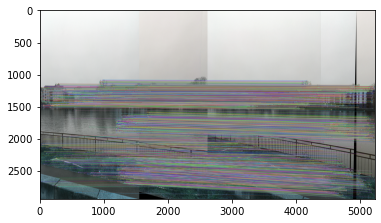

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
4 + 5


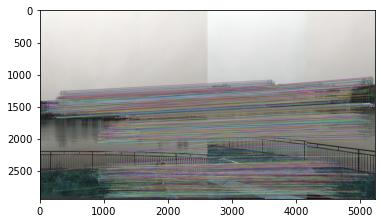

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
5 + 6


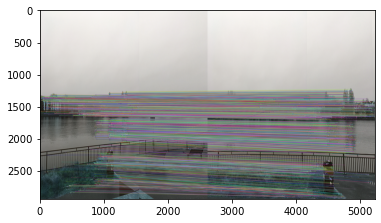

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
5
1 + 2


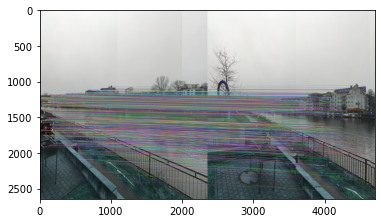

shape[0] = 2645
w_edge = 2644
(2645, 2644, 3)
2 + 3


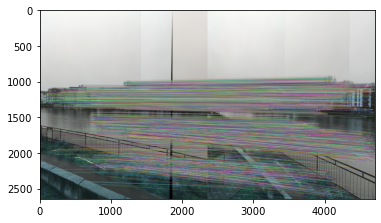

shape[0] = 2645
w_edge = 2644
(2645, 2644, 3)
3 + 4


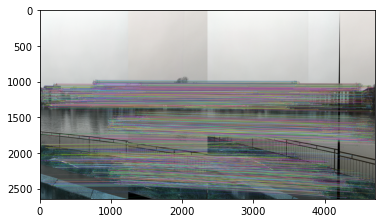

shape[0] = 2645
w_edge = 2644
(2645, 2644, 3)
4 + 5


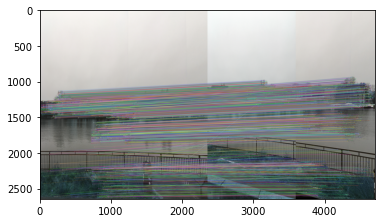

shape[0] = 2645
w_edge = 2644
(2645, 2644, 3)
4
1 + 2


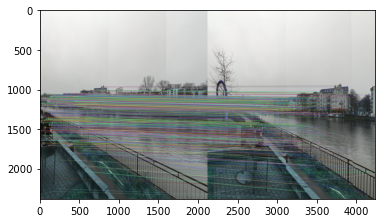

shape[0] = 2380
w_edge = 2379
(2380, 2379, 3)
2 + 3


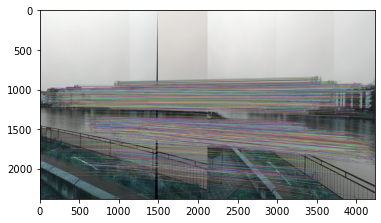

shape[0] = 2380
w_edge = 2379
(2380, 2379, 3)
3 + 4


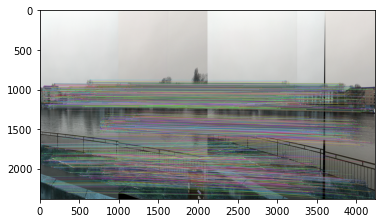

shape[0] = 2380
w_edge = 2379
(2380, 2379, 3)
3
1 + 2


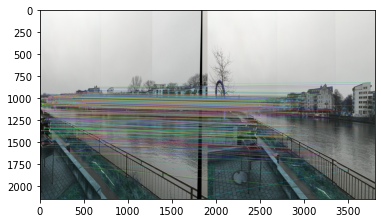

shape[0] = 2142
w_edge = 2141
(2142, 2141, 3)
2 + 3


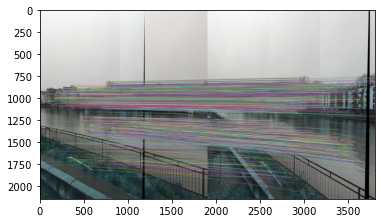

shape[0] = 2142
w_edge = 2141
(2142, 2141, 3)
2
1 + 2


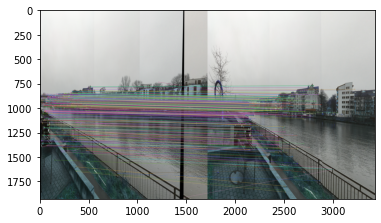

shape[0] = 1928
w_edge = 1927
(1928, 1927, 3)
1
(1928, 1927, 3)
seconds used: 1564


In [12]:
# Optimization
import os
import cv2
import matplotlib.pyplot as plt
from datetime import datetime


def process(img_list):
    while (len(img_list) > 1):
        merged_img_list = []
        for count in range(len(img_list) - 1):
            print(str(count + 1) + " + " + str(count + 2))
            merged_img_list.append(stich(img_list[count], img_list[count + 1]))
        img_list = merged_img_list
        print(len(img_list))
    return img_list[0]


def merge(dir_name):
    filename_list = os.listdir(dir_name)
    id_list = []
    for filename in filename_list:
        id = int(filename.split(".")[0])
        id_list.append(id)

    id_list.sort()
    print(id_list)
    img_list = []
    for id in id_list:
        img_list.append(cv2.imread(dir_name + str(id) + ".jpg"))
        # img_list.append(cv.imread(dir_name + str(id) + ".png"))
    return process(img_list)


start_time = datetime.now()
panorama = merge("data/")
print(panorama.shape)
end_time = datetime.now()
print("seconds used: " + str((end_time - start_time).seconds))
plt.imsave("panorama.jpg", panorama)

[1, 2, 3, 4]
1 + 2


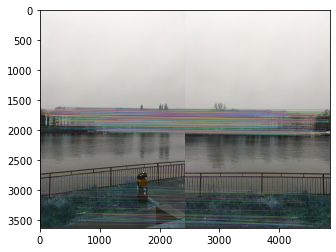

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
2 + 3


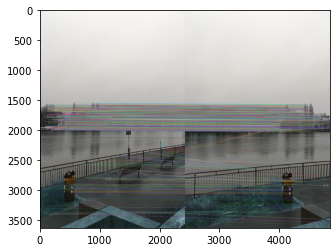

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
3 + 4


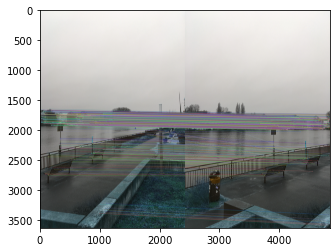

shape[0] = 3629
w_edge = 3628
(3629, 3628, 3)
3
1 + 2


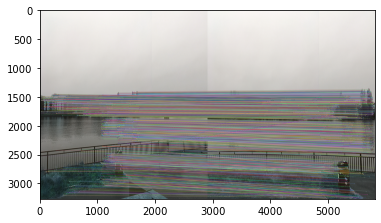

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
2 + 3


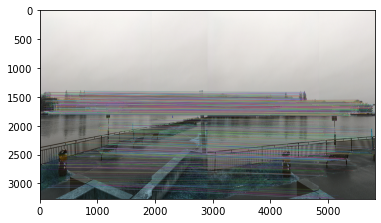

shape[0] = 3266
w_edge = 3265
(3266, 3265, 3)
2
1 + 2


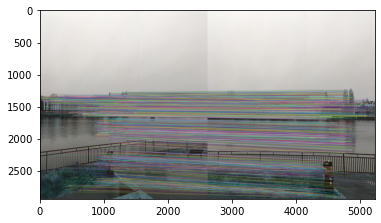

shape[0] = 2939
w_edge = 2938
(2939, 2938, 3)
1
(2939, 2938, 3)
seconds used: 363


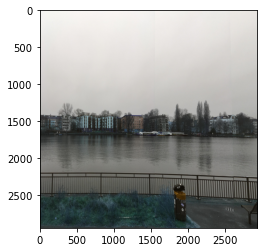

In [14]:
# Optimization
import os
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

start_time = datetime.now()
panorama = merge("data-min/")
print(panorama.shape)
end_time = datetime.now()
print("seconds used: " + str((end_time - start_time).seconds))
plt.imsave("panorama-min.jpg", panorama)
img = plt.imread("panorama-min.jpg")
plt.imshow(img)
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8]
Your Panorama is ready!!!
seconds used: 8


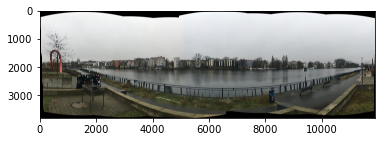

In [15]:
import cv2
import os
from datetime import datetime
from matplotlib import pyplot as plt

def stitch(dir_name):
    filename_list = os.listdir(dir_name)
    id_list = []
    for filename in filename_list:
        id = int(filename.split(".")[0])
        id_list.append(id)

    id_list.sort()
    print(id_list)
    img_list = []
    for id in id_list:
        img_list.append(cv2.imread(dir_name + str(id) + ".jpg"))
        # img_list.append(cv.imread(dir_name + str(id) + ".png"))
    stitchy = cv2.Stitcher.create()
    (dummy, output) = stitchy.stitch(img_list)
    return dummy, output

start_time = datetime.now()
dummy, output = stitch("data/")
if dummy != cv2.STITCHER_OK:
    # checking if the stitching procedure is successful
    # .stitch() function returns a true value if stitching is
    # done successfully
    print("stitching ain't successful")
else:
    print('Your Panorama is ready!!!')
    cv2.imwrite("output.jpg", output)
end_time = datetime.now()
print("seconds used: " + str((end_time - start_time).seconds))

output = plt.imread("output.jpg")
plt.imshow(output)
plt.show()